<a href="https://colab.research.google.com/github/kbr2788/vegabond/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kbr2788/vegabond/master/sentiment%20analysis/train_add.txt", filename="train_add.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/kbr2788/vegabond/master/sentiment%20analysis/test_pos.txt", filename="test_pos.txt")

('test_pos.txt', <http.client.HTTPMessage at 0x7f1e8f579a10>)

In [ ]:
train_data = pd.read_table('train_add.txt', encoding='UTF-8', error_bad_lines=False)
test_data = pd.read_table('test_pos.txt', encoding='UTF-8', error_bad_lines=False)

b'Skipping line 160764: expected 3 fields, saw 5\n'
b'Skipping line 50301: expected 3 fields, saw 5\n'


In [ ]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 161283


In [ ]:
train_data[:5]

,grade,document,label
0,1.0,지저분ㅠ,0.0
1,1.0,편의 시설이 안되네요,0.0
2,1.0,쓰레기장같았어요.여기저기 널려있는 쓰레기들...제발 쓰레기는 집으로 가져가세요~,0.0
3,1.0,관리 잘안되어있음,0.0
4,1.0,그늘이없음,0.0


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 50684


In [ ]:
test_data[:5]

,grade,document,label
0,1.0,"가난한 서비스\n이것은 나쁜 경험, 가난한 시스템, 비싼 요금, 혼잡, 플랫폼의 개...",0.0
1,1.0,그 더러운 좀 낡아 보였고\n너무 더럽고 오래된 홍콩의 지하철 역이 있고 믿을 수 ...,0.0
2,1.0,불편한 mrt\n한국처럼 장애인들은 편하게 이용하기가 어려운것 같아요.... 우리나...,0.0
3,1.0,이런\n지속적으로 사용하고 있어서 참 다 해 주시기 바랍니다. 자신을 생각하면 여행...,0.0
4,1.0,일터 근처라 바로 옆이다.\n그냥 한마디로 말하면 지저분하고 위생관리가 안된다. 솔...,0.0


In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(156673, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 156674


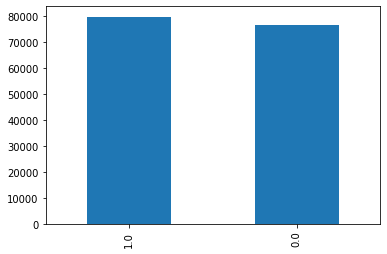

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0    0.0  76805
1    1.0  79867


In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

grade       1
document    1
label       2
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,grade,document,label
2352,NaN,NaN,NaN


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

156672


In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,grade,document,label
0,1.0,지저분ㅠ,0.0
1,1.0,편의 시설이 안되네요,0.0
2,1.0,쓰레기장같았어요여기저기 널려있는 쓰레기들제발 쓰레기는 집으로 가져가세요,0.0
3,1.0,관리 잘안되어있음,0.0
4,1.0,그늘이없음,0.0


In [ ]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

grade         0
document    393
label         0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,grade,document,label
4385,5.0,NaN,1.0
4391,4.0,NaN,1.0
4446,4.0,NaN,1.0
11347,7117896.0,NaN,0.0
11356,6478189.0,NaN,0.0


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

156279


In [ ]:
train_data.columns

Index(['grade', 'document', 'label'], dtype='object')

In [ ]:
test_data.columns

Index(['grade', 'document', 'label'], dtype='object')

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49294


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','호텔']

okt = Okt()
okt.morphs('걍 여기 오는것보다 차라리 호텔가서 자는게 더 나았을지도', stem = True)

['걍', '여기', '오다', '차라리', '호텔', '가다', '자다', '더', '나다']

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['지', '저', '분', 'ㅠ'], ['편의', '시설', '안되다'], ['쓰레기', '장', '같다', '여기저기', '널다', '있다', '쓰레기', '제발', '쓰레기', '집', '가져가다']]


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '있다': 4, '없다': 5, '좋다': 6, '이다': 7, '너무': 8, '않다': 9, '되다': 10, '다': 11, '적': 12, '정말': 13, '것': 14, '에서': 15, '같다': 16, '로': 17, '만': 18, '수': 19, '재밌다': 20, '아니다': 21, '진짜': 22, '점': 23, '사람': 24, '그': 25, '나': 26, '인': 27, '내': 28, '만들다': 29, '나오다': 30, '최고': 31, '연기': 32, '평점': 33, '생각': 34, '시간': 35, '안': 36, '더': 37, '많다': 38, '못': 39, '때': 40, '고': 41, '스토리': 42, '왜': 43, '게': 44, '가다': 45, '말': 46, '드라마': 47, '보고': 48, '감동': 49, '그냥': 50, '이렇다': 51, '곳': 52, '아깝다': 53, '요': 54, '하고': 55, '중': 56, '배우': 57, 'ㅋㅋ': 58, '아': 59, '까지': 60, '자다': 61, '거': 62, '재미있다': 63, '감독': 64, '재미': 65, '들다': 66, '주다': 67, '내용': 68, '뭐': 69, '볼': 70, '저': 71, '지루하다': 72, '쓰레기': 73, '싶다': 74, '네': 75, '우리': 76, '재미없다': 77, '그렇다': 78, '모르다': 79, '하나': 80, '오다': 81, '다시': 82, '지': 83, '사랑': 84, '알다': 85, '정도': 86, '작품': 87, '마지막': 88, '때문': 89, '하': 90, '돈': 91, '처음': 92, '이건': 93, '많이': 94, '완전': 95, '분': 96, 'ㅋ': 97, 'ㅠㅠ': 98, '개': 99, '년': 100, '느낌': 101, '안되다': 102, 'ㅋ

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47265
등장 빈도가 2번 이하인 희귀 단어의 수: 25751
단어 집합에서 희귀 단어의 비율: 54.4821749709087
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6388989169208965


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21516


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

155868
155868


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 568
리뷰의 평균 길이 : 12.422299638155362


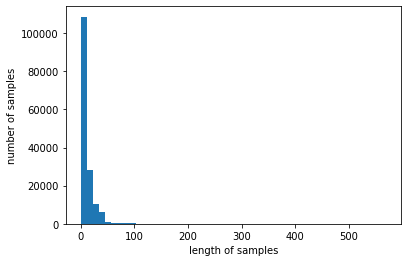

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 99.70359534991147


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2079/2079 [==============================] - 539s 258ms/step - loss: 0.4436 - acc: 0.7920 - val_loss: 0.3590 - val_acc: 0.8409

Epoch 00001: val_acc improved from -inf to 0.84093, saving model to best_model.h5
Epoch 2/15
2079/2079 [==============================] - 531s 256ms/step - loss: 0.3240 - acc: 0.8611 - val_loss: 0.3417 - val_acc: 0.8504

Epoch 00002: val_acc improved from 0.84093 to 0.85039, saving model to best_model.h5
Epoch 3/15
2079/2079 [==============================] - 532s 256ms/step - loss: 0.2925 - acc: 0.8763 - val_loss: 0.3288 - val_acc: 0.8558

Epoch 00003: val_acc improved from 0.85039 to 0.85584, saving model to best_model.h5
Epoch 4/15
2079/2079 [==============================] - 533s 256ms/step - loss: 0.2727 - acc: 0.8866 - val_loss: 0.3299 - val_acc: 0.8583

Epoch 00004: val_acc improved from 0.85584 to 0.85828, saving model to best_model.h5
Epoch 5/15
2079/2079 [==============================] - 529s 255ms/step - loss: 0.2560 - acc: 0.8950 - val_

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1541/1541 [==============================] - 53s 34ms/step - loss: 0.3358 - acc: 0.8541

 테스트 정확도: 0.8541


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("긍정:({:.2f}%)\n".format(score * 100))
  else:
    print("부정:({:.2f}%)\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('역시 경포 해변 깨끗하고 화장실도 호텔급')

긍정:(96.66%)



In [ ]:
sentiment_predict('너무 깨끗하고 다시 방문하고 싶은 곳')

98.73% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('화장실은 조금 더러웠지만 그거 빼고는 다 괜찮았다')

88.60% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('역시 경포해변 바다 깨끗하고 화장실도 굿')

98.77% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('역시 경포해변 바다 깨끗하고 화장실도 호텔급이었다!!')

95.67% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('역시 한국이 최고네요')

99.01% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('한국 바다중에 여기만큼 좋은 곳이 없어요')

85.48% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('최고급 호텔에서 지내는 기분이었어요 최고였습니다')

97.61% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('호텔에서 지내는 기분이었어요 최고였습니다')

98.55% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('굳이 호텔 가서 자지 않아도 괜찮았어요')

55.45% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('호텔급 시설')

54.01% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('여기 캠핑장 시설 호텔 수준임')

70.30% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('호텔 좋아요')

91.30% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('당일 캠핑으로 수도권에 사시는 분들은 이 곳 실미 해수욕장 추천합니다 다만 주말에는 사람이 많아 아침 8시 이전에 오지 않으면 자리 맡기기 쉽지 않습니다')

94.50% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('비수기 화장실 없어 매우 불편.')

88.11% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('실미도는 물때 안 맞으면 굳이 들어가지 마세요. 그냥 바닷가인데 서해 바다는 벌 때문에 그리 깨끗하지 않아요.')

88.08% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('시원한 소나무그늘에서  파도소리 들으며   시간가는줄   모르고 2박3일이   지나갔다  최근에 다리가 개통되어    주말이나휴일은 교통체증이  심하다고하니 주말을피해서   주중에오면 조용하게  즐길수있다')

98.02% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('무의도 다리 개통으로 접근성이 좋와짐,,하지만 화장실, 샤워장 시설이 아주 취약함,,그리고 주말에는 차들이 너무혼잡해서 피하시는게 좋을듯합니다.')

72.17% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('너무 복잡해서 다시는 안가고 싶어요.')

78.99% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('좋았는데 벌레가 너무 많아서 별로였어요. 사람들이 쓰레기좀 그만 버렸으면 좋겠어요.')

97.40% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('경치가 너무 좋았어요. 근데 사람이 너무 많았어요. 다음에는 사람 없을 때 와야겠어요.')

92.85% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('화장실도 더럽고 쓰레기 안가져가는 사람들은 양심이 너무 없네요. 시설 관리 좀 했으면 좋겠어요.')

87.30% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('제가 왔을때는 날씨가 너무 좋았어요. 그리고 평일에 왔는데 사람이 없어서 조용했어요. 유명해지지 않았으면 좋겠네요!')

90.10% 확률로 긍정 리뷰입니다.



In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kbr2788/vegabond/master/sentiment%20analysis/test_new.txt", filename="test_new.txt")

new_data = pd.read_table('test_new.txt', encoding='cp949')

In [ ]:
i=2
for s in new_data['document']:
  print(i)
  sentiment_predict(s)
  i+=1

2
긍정:(98.37%)

3
긍정:(97.84%)

4
긍정:(73.49%)

5
긍정:(74.05%)

6
긍정:(96.71%)

7
긍정:(73.40%)

8
긍정:(94.66%)

9
긍정:(99.41%)

10
부정:(80.32%)

11
긍정:(99.35%)

12
긍정:(94.93%)

13
긍정:(93.64%)

14
긍정:(98.49%)

15
긍정:(87.58%)

16
부정:(96.06%)

17
긍정:(99.50%)

18
긍정:(97.21%)

19
긍정:(97.65%)

20
긍정:(96.56%)

21
긍정:(81.89%)

22
긍정:(99.35%)

23
긍정:(99.81%)

24
긍정:(96.43%)

25
긍정:(99.23%)

26
긍정:(63.53%)

27
긍정:(99.12%)

28
긍정:(81.33%)

29
긍정:(60.62%)

30
긍정:(91.80%)

31
긍정:(94.48%)

32
긍정:(98.40%)

33
긍정:(99.19%)

34
긍정:(97.23%)

35
부정:(59.20%)

36
긍정:(98.68%)

37
긍정:(95.96%)

38
긍정:(96.06%)

39
긍정:(95.57%)

40
부정:(64.75%)

41
긍정:(67.66%)

42
긍정:(79.21%)

43
긍정:(94.30%)

44
긍정:(96.58%)

45
긍정:(96.52%)

46
긍정:(95.73%)

47
긍정:(79.32%)

48
긍정:(96.72%)

49
긍정:(96.24%)

50
긍정:(93.88%)

51
긍정:(83.89%)

52
긍정:(95.95%)

53
긍정:(99.15%)

54
부정:(76.16%)

55
긍정:(51.38%)

56
긍정:(93.33%)

57
긍정:(97.90%)

58
긍정:(98.82%)

59
긍정:(92.72%)

60
긍정:(98.88%)

61
부정:(50.27%)

62
긍정:(98.78%)

63
긍정:(98.03%)

64
부정:(52.56%)

